1	用いたデータセットのPubMedレコードの全件数は？
2	1つ以上の疾患MeSHタームまたは1つ以上の症状MeSHタームを含むレコードの件数(どちらかだけでも良い)は？
3	2は1の何%？
4	疾患MeSHタームかつ症状MeSHタームを含むレコードの件数(必ずどちらかが1ターム以上)は？
5	4に含まれる疾患MeSHタームの種類の数は？
6	4に含まれる症状MeSHタームの種類の数は？
7	MeSHデータベースに含まれる疾患MeSHタームの種類の数は？
8	MeSHデータベースに含まれる症状MeSHタームの種類の数は？
9	5は7の何%?
10	6は8の何%?
11	4の疾患-症状ペアの数は？
12	TF-IDFした後で、正のコサイン類似度を持つ疾患-疾患ペアの数は？
13	もっとも頻度の高い20疾患MeSHタームは？
14	もっとも頻度の高い20症状MeSHタームは？
15	次数のヒストグラムの形状は？
16	半分の疾患(4219/2=2110疾患)より大きい次数を持つ疾患MeSHタームの割合は？
17	もっとも次数の高い疾患MeSHタームは？
18	もっとも次数の低い疾患MeSHタームは？


In [1]:
import gzip
import xml.etree.ElementTree as ET
import defusedxml.ElementTree as ET
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict
import collections
from collections import Counter

import os
import pickle
import glob

In [2]:
os.chdir('/home/admin_user')

In [3]:
#MeSH 読込
with open('mesh_list_2011.pickle', 'rb') as f:
    mesh_list = pickle.load(f)

#メッシュから　メッシュIDと疾患/症状メッシュ、TreeNumber を取り出す
#疾患メッシュ：Cのうち C22（動物)とC23.888（症状）を除外したもの）＋F03（精神障害）
#症状メッシュ：C23.888
mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]
mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]
#さらにメッシュ名だけにする＋重複削除
mesh_diseases= pd.DataFrame(mesh_diseases)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()
mesh_symptoms= pd.DataFrame(mesh_symptoms)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()

len(mesh_list),len(mesh_diseases), len(mesh_symptoms)

100%|██████████| 26142/26142 [00:00<00:00, 1133928.61it/s]


(26142, 4475, 328)

In [4]:
import glob
os.chdir('/home/admin_user/デスクトップ/pubmed_csv_from_xml')
csv_list = sorted(glob.glob('pubmed21n*.csv'))
len(csv_list)

1062

In [5]:
#disease抽出, csv作成(定義)

def select_decriptor_disease(df):

    if len(df)>0:
        
        for x in collist:
            df[x]=df[x].str.split('|')
            df[x]=df[x].fillna({i: [] for i in df.index}) 
            
        desc_set = [[pmid,
                     descs,
                     desc_majrs,
                     qual_majrs,
                     pubdate] for pmid, descs, desc_majrs, qual_majrs, pubdate in zip(df["PMID"],#0
                                                                                      df["Descriptor"],#1
                                                                                      df["Descriptor_MajorTopic"],#2
                                                                                      df["Qualifier_MajorTopic"],#3
                                                                                      df["PubMedPubDate"])]#-1    
        disease_list=[]
        symptom_list=[]
        for i in desc_set:
            for desc, desc_majr, qual_majr in zip(i[1], i[2], i[3]):
                if desc in mesh_diseases:
                    disease_list.append([i[0], desc, desc_majr, qual_majr, i[-1][0]])

                    
        disease_df = pd.DataFrame(disease_list, columns=["PMID", "disease", "desc_majr", "qual_majr", "pubdate"])
        disease_df["PubMedPubDate"] = pd.to_datetime(disease_df["pubdate"])
        del disease_df["pubdate"]
        
        #make csv
        os.chdir(path_2)
        disease_df.to_csv(file[:-4]+"_d.csv", index=False)
        os.chdir(path_1)
        
    else:
        disease_df = pd.DataFrame(columns=["PMID", "disease", "desc_majr", "qual_majr", "pubdate"])
        
        #make csv
        os.chdir(path_2)
        disease_df.to_csv(file[:-4]+"_d.csv", index=False)
        os.chdir(path_1)
                
    return

In [6]:
#disease抽出, csv作成(実行)

path_1 = '/home/admin_user/デスクトップ/pubmed_csv_from_xml'
path_2 = '/home/admin_user/デスクトップ/pubmed_d_2011'

os.chdir(path_1)

collist = ["Descriptor", "Descriptor_MajorTopic","Qualifier_MajorTopic", "PubMedPubDate"]
csv_list = sorted(glob.glob('pubmed21n*.csv'))
for file in tqdm(csv_list):  
    df = pd.read_csv(file, engine='python')
    df = df[~df["Descriptor"].isna()]
    select_decriptor_disease(df)

100%|██████████| 1062/1062 [5:23:06<00:00, 18.25s/it] 


In [7]:
#csv読込、diseas_MeSHをさらにMajorTopicで絞り込む

os.chdir(path_2)

disease_df=pd.DataFrame()
csv_list = sorted(glob.glob('pubmed21n*_d.csv'))
for file in tqdm(csv_list):
    tmp_df = pd.read_csv(file, engine='python')
    tmp_df = tmp_df[ (tmp_df["desc_majr"]=="Y") | ( (tmp_df["desc_majr"]=="N") & (tmp_df["qual_majr"]=="Y") ) ]
    disease_df = pd.concat([disease_df, tmp_df])
disease_df = disease_df.reset_index(drop=True)
print(len(disease_df))

100%|██████████| 1062/1062 [08:49<00:00,  2.01it/s]


15972592


In [8]:
#symptom抽出, csv作成(定義)

def select_decriptor_symptom(df):

    if len(df)>0:
        
        for x in collist:
            df[x]=df[x].str.split('|')
            df[x]=df[x].fillna({i: [] for i in df.index}) 
            
        desc_set = [[pmid,
                     descs,
                     desc_majrs,
                     qual_majrs,
                     pubdate] for pmid, descs, desc_majrs, qual_majrs, pubdate in zip(df["PMID"],#0
                                                                                      df["Descriptor"],#1
                                                                                      df["Descriptor_MajorTopic"],#2
                                                                                      df["Qualifier_MajorTopic"],#3
                                                                                      df["PubMedPubDate"])]#-1    

        symptom_list=[]
        for i in desc_set:
            for desc, desc_majr, qual_majr in zip(i[1], i[2], i[3]):
                if desc in mesh_symptoms:
                    symptom_list.append([i[0], desc, i[-1][0]])
        
        symptom_df = pd.DataFrame(symptom_list, columns=["PMID", "symptom", "pubdate"])
        symptom_df["PubMedPubDate"] = pd.to_datetime(symptom_df["pubdate"])
        del symptom_df["pubdate"]    
        
        
        #make csv
        os.chdir(path_2)
        symptom_df.to_csv(file[:-4]+"_s.csv", index=False)        
        os.chdir(path_1)
        
    else:
        symptom_df = pd.DataFrame(columns=["PMID", "symptom", "PubMedPubDate"])
        
        #make csv
        os.chdir(path_2)
        symptom_df.to_csv(file[:-4]+"_s.csv", index=False)        
        os.chdir(path_1)
                
    return

In [10]:
#symptom抽出, csv作成(実行)

path_1 = '/home/admin_user/デスクトップ/pubmed_csv_from_xml'
path_2 = '/home/admin_user/デスクトップ/pubmed_s_2011'

os.chdir(path_1)

collist = ["Descriptor", "Descriptor_MajorTopic","Qualifier_MajorTopic", "PubMedPubDate"]
csv_list = sorted(glob.glob('pubmed21n*.csv'))
for file in tqdm(csv_list):  
    df = pd.read_csv(file, engine='python')
    df = df[~df["Descriptor"].isna()]
    select_decriptor_symptom(df)

100%|██████████| 1062/1062 [33:19<00:00,  1.88s/it]


In [11]:
#symptom csv読込

os.chdir(path_2)
symptom_df=pd.DataFrame()
csv_list = sorted(glob.glob('pubmed21n*_s.csv'))
print(len(csv_list))

for file in tqdm(csv_list):
    tmp_df = pd.read_csv(file, engine='python')   
    symptom_df = pd.concat([symptom_df, tmp_df])
symptom_df = symptom_df.reset_index(drop=True)
print(len(symptom_df))

  1%|▏         | 15/1062 [00:00<00:06, 149.72it/s]

1062


100%|██████████| 1062/1062 [00:36<00:00, 29.21it/s]

2318332


In [12]:
del disease_df["pubdate"]

In [15]:
disease_df[ (disease_df["desc_majr"]=="N") & (disease_df["qual_majr"]=='N')]

,PMID,disease,desc_majr,qual_majr,PubMedPubDate


In [14]:
#使いたいメッシュを取り出せたのでcsv保存
print(len(disease_df), len(symptom_df))

os.chdir('/home/admin_user/デスクトップ/pubmed_descriptor')
disease_df.to_csv("disease_df_2011.csv", index="False")
symptom_df.to_csv("symptom_df_2011.csv", index="False")

15972592 2318332


In [4]:

os.chdir('/home/admin_user/デスクトップ/pubmed_descriptor')

#2011MeSH disease, symptom
disease_df =pd.read_csv("disease_df_2011.csv") 
symptom_df =pd.read_csv("symptom_df_2011.csv")
print(len(disease_df), len(symptom_df))

15972592 2318332


In [5]:
#disease_df(Majrtopic OK)
#symptom_df

#MajorTopicは済んだので次に期間を絞り込む

#1966 START
disease_df_1966_new = disease_df[ (disease_df['PubMedPubDate']>="1966-01-01") ]
symptom_df_1966_new = symptom_df[ (symptom_df['PubMedPubDate']>="1966-01-01") ]

#Zhou
disease_df_zhou = disease_df[ (disease_df['PubMedPubDate']>="1966-01-01") & (disease_df["PubMedPubDate"]<"2011-11-01")]
symptom_df_zhou = symptom_df[ (symptom_df['PubMedPubDate']>="1966-01-01") & (symptom_df["PubMedPubDate"]<"2011-11-01")]


In [6]:
df_list = ["disease_df", "disease_df_1966_new", "disease_df_zhou",
           "symptom_df", "symptom_df_1966_new", "symptom_df_zhou"]

#文献数, pubmedpubdate
for i in df_list:
    print(i,  ":", eval(i)["PMID"].nunique(), eval(i)["PubMedPubDate"].min(), eval(i)["PubMedPubDate"].max())

disease_df : 10476583 1902-03-01 2020-12-01
disease_df_1966_new : 9322303 1966-01-01 2020-12-01
disease_df_zhou : 6526807 1966-01-01 2011-10-29
symptom_df : 1923798 1940-06-08 2020-11-29
symptom_df_1966_new : 1806238 1966-01-01 2020-11-29
symptom_df_zhou : 1278538 1966-01-01 2011-10-29


In [7]:
#mesh数
#disease
print("disease_MeSH: ", [ [ i, eval(i)["disease"].nunique()] for i in df_list[:3]])
#symptom
print("symptom_MeSH: ", [ [ i, eval(i)["symptom"].nunique()] for i in df_list[3:]])

disease_MeSH:  [['disease_df', 4409], ['disease_df_1966_new', 4408], ['disease_df_zhou', 4405]]
symptom_MeSH:  [['symptom_df', 319], ['symptom_df_1966_new', 318], ['symptom_df_zhou', 318]]


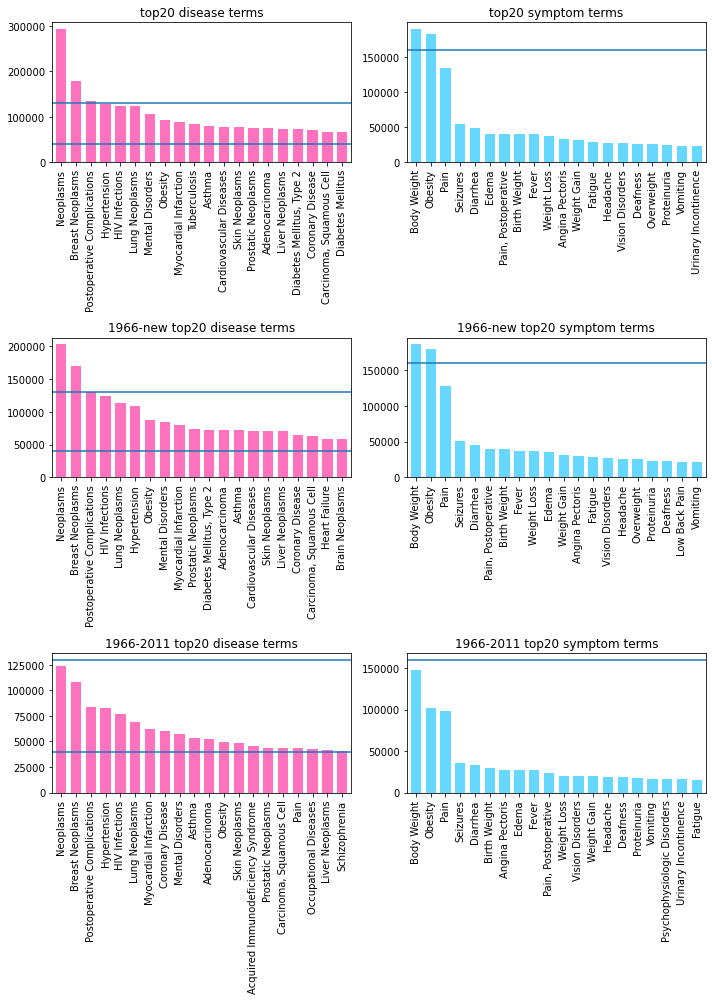

In [8]:
#共起ペアにする前の様子
#疾患メッシュ症状メッシュの出現数top20 

import matplotlib.pyplot as plt
plt.figure(figsize=(10,14))

#disease_df, symptom_df
plt.subplot(321)
disease_df["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepPink', title='top20 disease terms')#alpha=0.5
plt.axhline(y=40000)
plt.axhline(y=130000)
#plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(322)
symptom_df["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepSkyBlue', title='top20 symptom terms')
plt.axhline(y=160000)
#plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])

#disease_df_1966_new, symptom_df_1966_new
plt.subplot(323)
disease_df_1966_new["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepPink', title='1966-new top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)

plt.subplot(324)
symptom_df_1966_new["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepSkyBlue', title='1966-new top20 symptom terms')
plt.axhline(y=160000)


#disease_df_zhou symptom_df_zhou
plt.subplot(325)
disease_df_zhou["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepPink', title='1966-2011 top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)

plt.subplot(326)
symptom_df_zhou["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DeepSkyBlue', title='1966-2011 top20 symptom terms')
plt.axhline(y=160000)


plt.tight_layout()
plt.show()


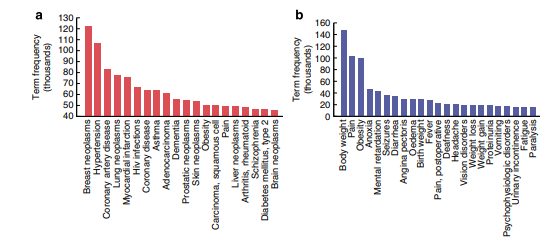

In [11]:
from IPython.display import Image
Image("/home/admin_user/キャプチャbarabasi.PNG")


In [9]:
#"disease_df", "symptom_df"

# disease|symptom どちらかを持つ文献数
print(len(sorted(list(set(disease_df["PMID"]) | set(symptom_df["PMID"])))))
print(pd.concat([disease_df, symptom_df])["PMID"].nunique())

# disease&symptom ペアを持つ文献数
print(len(sorted(list(set(disease_df["PMID"]) & set(symptom_df["PMID"])))))
print(pd.merge(disease_df, symptom_df, on=["PMID", "PubMedPubDate"])["PMID"].nunique())

11202498
11202498
1197883
1197883


In [10]:
#"disease_df_1966_new", "symptom_df_1966_new"

# disease|symptom どちらかを持つ文献数
print(len(sorted(list(set(disease_df_1966_new["PMID"]) | set(symptom_df_1966_new["PMID"])))))
print(pd.concat([disease_df_1966_new, symptom_df_1966_new])["PMID"].nunique())

# disease&symptom ペアを持つ文献数
print(len(sorted(list(set(disease_df_1966_new["PMID"]) & set(symptom_df_1966_new["PMID"])))))
print(pd.merge(disease_df_1966_new, symptom_df_1966_new, on=["PMID", "PubMedPubDate"])["PMID"].nunique())

10033286
10033286
1095255
1095255


In [11]:
#"disease_df_zhou", "symptom_df_zhou"

# disease|symptom どちらかを持つ文献数
print(len(sorted(list(set(disease_df_zhou["PMID"]) | set(symptom_df_zhou["PMID"])))))
print(pd.concat([disease_df_zhou, symptom_df_zhou])["PMID"].nunique())
# disease&symptom ペアを持つ文献数
print(len(sorted(list(set(disease_df_zhou["PMID"]) & set(symptom_df_zhou["PMID"])))))
print(pd.merge(disease_df_zhou, symptom_df_zhou, on=["PMID", "PubMedPubDate"])["PMID"].nunique())


7036976
7036976
768369
768369


#全文献数 31,850,055 
#xmlを読み込んだcsvからpmidの数を数える
each_csv_has_pmids=[]
for file in tqdm(csv_list[:]):
    tmp_df = pd.read_csv(file, engine='python', usecols=[0,6])#0=pmid, 6=Descriptor
    each_csv_has_pmids.append(len(tmp_df))
#31850055

In [ ]:
#####

In [ ]:
#disease_df, symptom_df
#disease_df_1966_new, symptom_df_1966_new
#disease_df_zhou, symptom_df_zhou

In [12]:
#2011Mesh 疾患症状ペアを作成
pmid_ds_pair_m2011 = pd.merge(disease_df, symptom_df, on=["PMID", "PubMedPubDate"])
pmid_ds_pair_m2011_1966_new = pd.merge(disease_df_1966_new, symptom_df_1966_new, on=["PMID", "PubMedPubDate"])
pmid_ds_pair_m2011_zhou = pd.merge(disease_df_zhou, symptom_df_zhou, on=["PMID", "PubMedPubDate"])
print(len(pmid_ds_pair_m2011), len(pmid_ds_pair_m2011_1966_new), len(pmid_ds_pair_m2011_zhou))
#2465351 2124228 1482314


2465351 2124228 1482314


In [13]:
#疾患症状ペアデータ保存
os.chdir('/home/admin_user/デスクトップ/data')
pmid_ds_pair_m2011.to_csv("pmid_ds_pair_m2011.csv", index=False)
pmid_ds_pair_m2011_1966_new.to_csv("pmid_ds_pair_m2011_1966_new.csv", index=False)
pmid_ds_pair_m2011_zhou.to_csv("pmid_ds_pair_m2011_zhou.csv", index=False)

<ipython-input-14-275ddacf2ce4>:11: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)
<ipython-input-14-275ddacf2ce4>:11: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)


pmid_ds_pair_m2011 :ポイントの数は共起頻度数の種類数 62


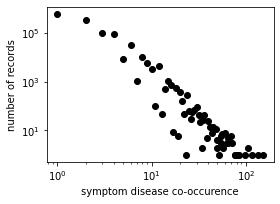

pmid_ds_pair_m2011_1966_new :ポイントの数は共起頻度数の種類数 33


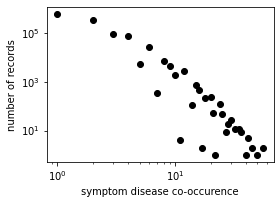

pmid_ds_pair_m2011_zhou :ポイントの数は共起頻度数の種類数 33


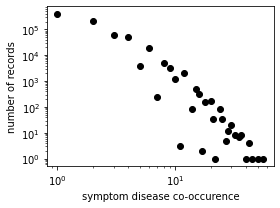

In [14]:
#一文献が持つペアの個数（co_occurence）とその文献の数(PMID_freq)
mydict= {"pmid_ds_pair_m2011":pmid_ds_pair_m2011, 
         "pmid_ds_pair_m2011_1966_new":pmid_ds_pair_m2011_1966_new,
         "pmid_ds_pair_m2011_zhou":pmid_ds_pair_m2011_zhou}
for name, item in mydict.items():
    freq_df = pd.DataFrame(item["PMID"].value_counts()).rename(columns={"PMID":'co_occurence'}).reset_index()
    freq_df = freq_df.rename(columns={"index":'PMID'})
    freq_df = freq_df.groupby('co_occurence').count().sort_index(ascending=False).rename(columns={"PMID":'PMID_freq'}).reset_index()
    plt.figure(figsize=(4,3))
    plt.scatter(freq_df["co_occurence"], freq_df["PMID_freq"], color="black")
    plt.loglog(basex=10,basey=10)
    plt.xlabel("symptom disease co-occurence",)#,fontsize=20)
    plt.ylabel("number of records")#,fontsize=20)
    print(name, ":ポイントの数は共起頻度数の種類数", len(freq_df))
    plt.tight_layout()
    plt.show()

In [15]:
print("出現したds_pairペア数の合計, 種類数, disease_MeSHの種類数, symptom_MeSHの種類数")
for name, item in mydict.items():
    print(name, len(item), len(item[["disease", 'symptom']].value_counts()), item["disease"].nunique(), item["symptom"].nunique())

出現したds_pairペア数の合計, 種類数, disease_MeSHの種類数, symptom_MeSHの種類数
pmid_ds_pair_m2011 2465351 176054 4305 319
pmid_ds_pair_m2011_1966_new 2124228 161677 4293 318
pmid_ds_pair_m2011_zhou 1482314 135250 4186 318


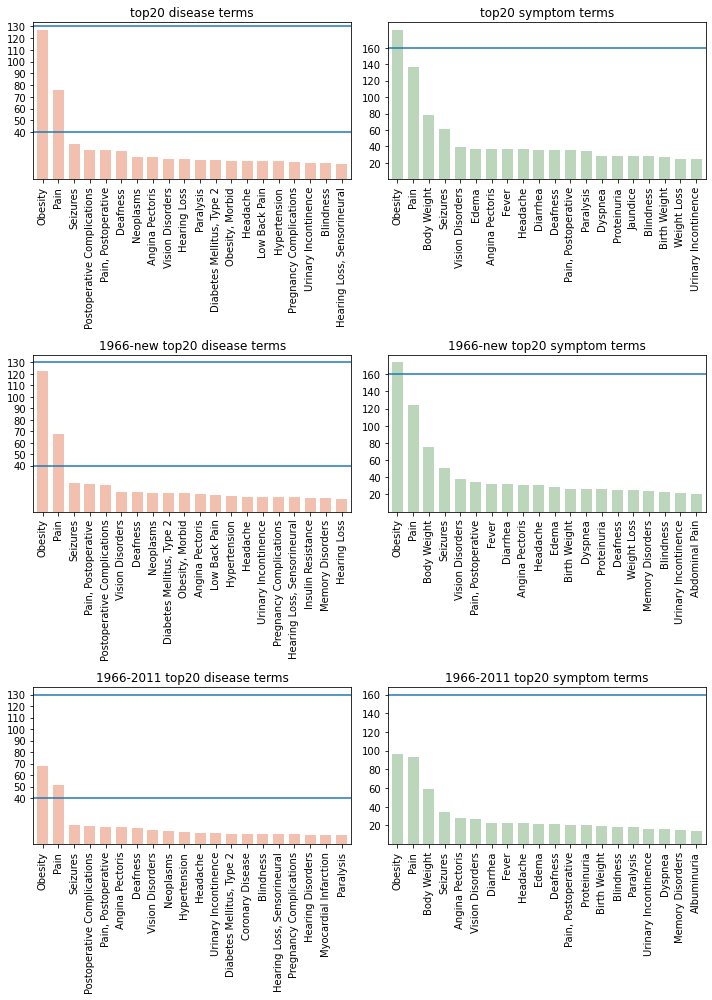

In [16]:
#疾患症状ペアの様子  DarkSalmon DarkSeaGreen
#疾患メッシュ症状メッシュの出現数top20

import matplotlib.pyplot as plt
plt.figure(figsize=(10,14))

#pmid_ds_pair_m2011
plt.subplot(321)
pmid_ds_pair_m2011["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSalmon', title='top20 disease terms')#alpha=0.5
plt.axhline(y=40000)
plt.axhline(y=130000)
plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(322)
pmid_ds_pair_m2011["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSeaGreen', title='top20 symptom terms')
plt.axhline(y=160000)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])

#pmid_ds_pair_m2011_1966_new
plt.subplot(323)
pmid_ds_pair_m2011_1966_new["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSalmon', title='1966-new top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)
plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(324)
pmid_ds_pair_m2011_1966_new["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSeaGreen', title='1966-new top20 symptom terms')
plt.axhline(y=160000)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])

#pmid_ds_pair_m2011_zhou
plt.subplot(325)
pmid_ds_pair_m2011_zhou["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSalmon', title='1966-2011 top20 disease terms')
plt.axhline(y=40000)
plt.axhline(y=130000)
plt.yticks([40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000],[40, 50, 60, 70, 80, 90, 100, 110, 120 ,130])

plt.subplot(326)
pmid_ds_pair_m2011_zhou["symptom"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='DarkSeaGreen', title='1966-2011 top20 symptom terms')
plt.axhline(y=160000)
plt.yticks([20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000],[20, 40, 60, 80, 100, 120, 140, 160])


plt.tight_layout()
plt.show()